In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import normalize
np.random.seed(0x5eed)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
num_bins = 10

In [46]:
predictions = np.genfromtxt("data/svhn/svhn_predictions.txt", delimiter=' ', dtype = float)
df = pd.DataFrame(predictions[:,0].astype(int), columns=['Correct'])
df['Predicted'] = np.argmax(predictions[:,1:11], axis=1)
df['Confidence'] = np.max(predictions[:,1:11], axis=1)
df = df.reset_index()

id2class = {i:i for i in range(10)}
n_classes = len(id2class)

In [48]:
def EceEval(confidence, y, num_bins=10):
    bins = np.linspace(0, 1, num_bins+1)
    digitized = np.digitize(confidence, bins[1:-1])
    
    w = np.array([(digitized==i).sum() for i in range(num_bins)])
    w = w/sum(w)

    confidence_bins = np.array([confidence[digitized==i].mean() for i in range(num_bins)])
    accuracy_bins = np.array([y[digitized==i].mean() for i in range(num_bins)])
    confidence_bins[np.isnan(confidence_bins)] = 0
    accuracy_bins[np.isnan(accuracy_bins)] = 0
    diff = np.absolute(confidence_bins - accuracy_bins)
    ece = np.inner(diff,w)
    return ece

In [49]:
column_names = ['Predicted_Class_k', 'R_k', 'N_k','Acc_k', 'Conf_k', 'ECE_k', 'Calibration_Bias_k']
output_df = pd.DataFrame(np.zeros((n_classes,len(column_names))), columns = column_names) 

output_df['Predicted_Class_k'] = [id2class[id] for id in id2class]
output_df['R_k'] = [df[(df['Correct']==id2class[id]) & (df['Predicted']==id2class[id])].shape[0] for id in range(n_classes)]
output_df['N_k'] = [df[(df['Predicted']==id2class[id])].shape[0] for id in range(n_classes)]
output_df['Acc_k'] = output_df['R_k'] / output_df['N_k']
output_df['Conf_k'] = [df[(df['Predicted']==id2class[id])]['Confidence'].mean() for id in id2class]
output_df['Calibration_Bias_k'] = output_df['Conf_k'] - output_df['Acc_k']
for class_idx in range(n_classes):
    mask = (df['Predicted']==id2class[class_idx])
    confidence = df[mask]['Confidence']
    y = df[mask]['Correct'] == df[mask]['Predicted']
    output_df['ECE_k'][class_idx] = EceEval(confidence, y, num_bins=num_bins)
output_df.to_csv('svhn_output_df.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


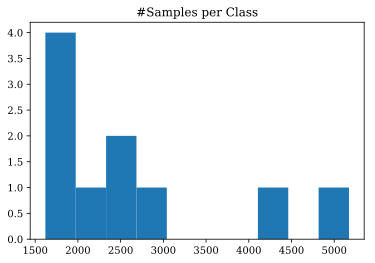

<Figure size 432x288 with 0 Axes>

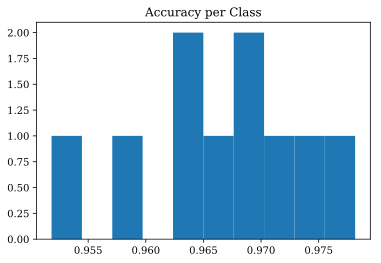

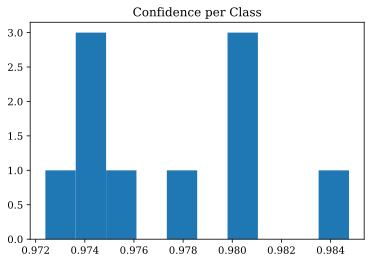

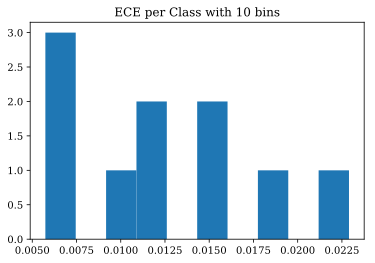

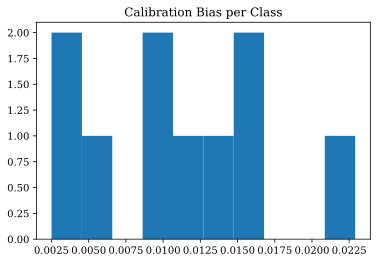

In [53]:
plt.figure();
plt.hist(output_df['N_k'],bins=10);
plt.title('#Samples per Class');
plt.figure();
plt.figure();
plt.hist(output_df['Acc_k'],bins=10);
plt.title('Accuracy per Class');
plt.figure();
plt.hist(output_df['Conf_k'],bins=10);
plt.title('Confidence per Class');
plt.figure();
plt.hist(output_df['ECE_k'],bins=10);
plt.title('ECE per Class with %d bins' % num_bins);
plt.figure();
plt.hist(output_df['Calibration_Bias_k'],bins=10);
plt.title('Calibration Bias per Class');

In [54]:
# class with loweest accuracy
output_df.sort_values('Acc_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
9,9,1541,1619,0.951822,0.974722,0.022900,0.022900
3,3,2727,2849,0.957178,0.972394,0.017927,0.015216
6,6,1903,1974,0.964032,0.974585,0.011496,0.010552
0,0,1697,1760,0.964205,0.977736,0.014886,0.013531
1,1,4998,5173,0.966171,0.981019,0.015929,0.014848
5,5,2289,2364,0.968274,0.980674,0.012400,0.012400
8,8,1612,1664,0.968750,0.974264,0.007329,0.005514
7,7,1924,1978,0.972700,0.975302,0.007234,0.002602
4,4,2464,2529,0.974298,0.984750,0.010452,0.010452
2,2,4032,4122,0.978166,0.980671,0.005740,0.002505


In [55]:
# class with loweest calibration bias
output_df.sort_values('Calibration_Bias_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
2,2,4032,4122,0.978166,0.980671,0.005740,0.002505
7,7,1924,1978,0.972700,0.975302,0.007234,0.002602
8,8,1612,1664,0.968750,0.974264,0.007329,0.005514
4,4,2464,2529,0.974298,0.984750,0.010452,0.010452
6,6,1903,1974,0.964032,0.974585,0.011496,0.010552
5,5,2289,2364,0.968274,0.980674,0.012400,0.012400
0,0,1697,1760,0.964205,0.977736,0.014886,0.013531
1,1,4998,5173,0.966171,0.981019,0.015929,0.014848
3,3,2727,2849,0.957178,0.972394,0.017927,0.015216
9,9,1541,1619,0.951822,0.974722,0.022900,0.022900


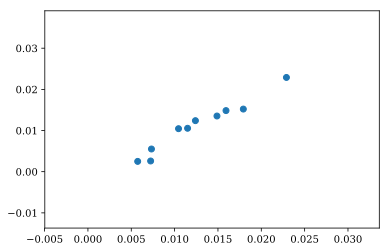

In [56]:
plt.scatter(output_df['ECE_k'], output_df['Calibration_Bias_k'])